## **Load Kaggle API & Download Dataset**

In [1]:
# Initialize Kaggle API
!mkdir -p ./dataset
!cp kaggle.json ./dataset
!chmod 600 ./dataset/kaggle.json
!rm kaggle.json

cp: kaggle.json: No such file or directory
chmod: ./dataset/kaggle.json: No such file or directory
rm: kaggle.json: No such file or directory


In [2]:
!kaggle datasets download -d irkaal/foodcom-recipes-and-reviews -p dataset

Dataset URL: https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews
License(s): CC0-1.0
  0%|▏                                      | 3.00M/723M [00:01<05:42, 2.21MB/s]^C
  0%|▏                                       | 3.00M/723M [00:04<16:35, 758kB/s]
User cancelled operation


In [ ]:
!unzip ./dataset/foodcom-recipes-and-reviews.zip -d ./dataset/
!rm ./dataset/foodcom-recipes-and-reviews.zip

Archive:  ./dataset/foodcom-recipes-and-reviews.zip
  inflating: ./dataset/recipes.csv   
  inflating: ./dataset/recipes.parquet  
  inflating: ./dataset/reviews.csv   
  inflating: ./dataset/reviews.parquet  


## **Import Library**

In [4]:
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install textblob pyspellchecker

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import pylab
import scipy.stats as stats
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from autocorrect import Speller
from textblob import TextBlob
from spellchecker import SpellChecker

In [7]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/raihanromzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raihanromzi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raihanromzi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [458]:
df=pd.read_csv('./dataset/recipes.csv')

In [459]:
df.head(2)

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."


In [460]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  RecipeIngredientQuantities  522514 non-null  object 
 13  RecipeIngredie

## **Data Visualization**

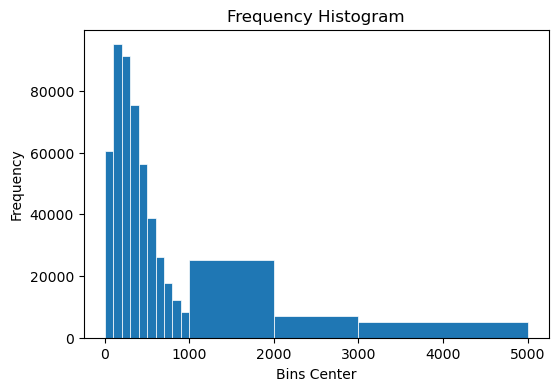

In [385]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.title('Frequency Histogram')
plt.ylabel('Frequency')
plt.xlabel('Bins Center')
ax.hist(df.Calories.to_numpy(),bins=[0,100,200,300,400,500,600,700,800,900,1000,2000,3000,5000],linewidth=0.5, edgecolor="white")
plt.show()

**Summary:** The histogram provides a visual representation of the distribution of calorie values in the dataset. This helps in understanding how calories are spread across different recipes.

**Insight:** The histogram indicates that most recipes have calories within the lower range (0-1000 calories), with significantly fewer recipes having higher calorie counts.

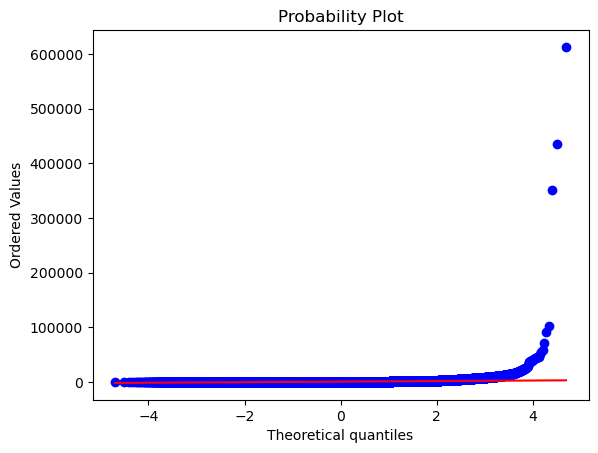

In [386]:
stats.probplot(df.Calories.to_numpy(), dist="norm", plot=pylab)
pylab.show()

**Summary:**
*   The majority of the recipes have calories in the lower range (0-1000 calories)
*   The data is highly skewed towards the lower calorie range, indicating that most recipes are under 1000 in calories.
*   There are several extreme values (outliers) in the higher calorie range, as indicated by the points far from the line.

**Insights:**
*   There is some outlier in calories (too high)

## **Data Preparation**

### Select Relevant Column for Building RecSys

In [461]:
columns=['RecipeId', 'Name','RecipeIngredientParts','RecipeInstructions', 'Images', 'Description', 'Keywords', 'RecipeCategory', 'Calories','FatContent','SaturatedFatContent','CholesterolContent','SodiumContent','CarbohydrateContent','FiberContent','SugarContent','ProteinContent']
df=df[columns]

### Filter Recipe to Follow this Max Nutritient

In [462]:
# https://www.dietaryguidelines.gov/
max_Calories=1000

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_fat=100

# https://www.heart.org/
max_daily_Saturatedfat=13

# https://www.dietaryguidelines.gov/
max_daily_Cholesterol=300

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Sodium=2300

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Carbohydrate=325

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Fiber=40

# https://www.heart.org/
max_daily_Sugar=40

# https://www.ncbi.nlm.nih.gov/books/NBK56068/
max_daily_Protein=200

max_list=[max_Calories,max_daily_fat,max_daily_Saturatedfat,max_daily_Cholesterol,max_daily_Sodium,max_daily_Carbohydrate,max_daily_Fiber,max_daily_Sugar,max_daily_Protein]

In [463]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   RecipeId               522517 non-null  int64  
 1   Name                   522517 non-null  object 
 2   RecipeIngredientParts  522517 non-null  object 
 3   RecipeInstructions     522517 non-null  object 
 4   Images                 522516 non-null  object 
 5   Description            522512 non-null  object 
 6   Keywords               505280 non-null  object 
 7   RecipeCategory         521766 non-null  object 
 8   Calories               522517 non-null  float64
 9   FatContent             522517 non-null  float64
 10  SaturatedFatContent    522517 non-null  float64
 11  CholesterolContent     522517 non-null  float64
 12  SodiumContent          522517 non-null  float64
 13  CarbohydrateContent    522517 non-null  float64
 14  FiberContent           522517 non-nu

In [465]:
df.columns[8:]

Index(['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent'],
      dtype='object')

In [466]:
# from index 6 to 14 which contain nutritional value with the corresponding maximum value in max_list
for column,maximum in zip(df.columns[8:],max_list):
    df=df[df[column]<maximum]

In [467]:
df.head(2)

,RecipeId,Name,RecipeIngredientParts,RecipeInstructions,Images,Description,Keywords,RecipeCategory,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,38,Low-Fat Berry Blue Frozen Dessert,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_...",Make and share this Low-Fat Berry Blue Frozen ...,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...",Frozen Desserts,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
3,41,Carina's Tofu-Vegetable Kebabs,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_...",This dish is best prepared a day in advance to...,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...",Soy/Tofu,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3


In [468]:
df.isnull().sum()

RecipeId                     0
Name                         0
RecipeIngredientParts        0
RecipeInstructions           0
Images                       0
Description                  2
Keywords                 12052
RecipeCategory             492
Calories                     0
FatContent                   0
SaturatedFatContent          0
CholesterolContent           0
SodiumContent                0
CarbohydrateContent          0
FiberContent                 0
SugarContent                 0
ProteinContent               0
dtype: int64

In [469]:
# DropNaN, Reset Index, Drop Duplicates
df = df.dropna()
df = df.reset_index(drop=True)
df = df.drop_duplicates(subset='Name', keep='first')
df = df.drop_duplicates(subset='RecipeIngredientParts', keep='first')
df = df.drop_duplicates(subset='RecipeInstructions', keep='first')

In [470]:
df.isnull().sum()

RecipeId                 0
Name                     0
RecipeIngredientParts    0
RecipeInstructions       0
Images                   0
Description              0
Keywords                 0
RecipeCategory           0
Calories                 0
FatContent               0
SaturatedFatContent      0
CholesterolContent       0
SodiumContent            0
CarbohydrateContent      0
FiberContent             0
SugarContent             0
ProteinContent           0
dtype: int64

In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297334 entries, 0 to 362409
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   RecipeId               297334 non-null  int64  
 1   Name                   297334 non-null  object 
 2   RecipeIngredientParts  297334 non-null  object 
 3   RecipeInstructions     297334 non-null  object 
 4   Images                 297334 non-null  object 
 5   Description            297334 non-null  object 
 6   Keywords               297334 non-null  object 
 7   RecipeCategory         297334 non-null  object 
 8   Calories               297334 non-null  float64
 9   FatContent             297334 non-null  float64
 10  SaturatedFatContent    297334 non-null  float64
 11  CholesterolContent     297334 non-null  float64
 12  SodiumContent          297334 non-null  float64
 13  CarbohydrateContent    297334 non-null  float64
 14  FiberContent           297334 non-null  f

## **Data Pre-Processing**

In [472]:
df_preprocessing=df.copy()

In [473]:
df_preprocessing.head(2)

,RecipeId,Name,RecipeIngredientParts,RecipeInstructions,Images,Description,Keywords,RecipeCategory,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent
0,38,Low-Fat Berry Blue Frozen Dessert,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_...",Make and share this Low-Fat Berry Blue Frozen ...,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...",Frozen Desserts,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2
1,41,Carina's Tofu-Vegetable Kebabs,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_...",This dish is best prepared a day in advance to...,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...",Soy/Tofu,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3


In [474]:
# Define column for pre-processing
columns=['Name', 'Keywords', 'Description', 'RecipeIngredientParts','RecipeInstructions', 'Images', 'RecipeCategory']
df_preprocessing=df_preprocessing[columns]
df_preprocessing.head(2)

,Name,Keywords,Description,RecipeIngredientParts,RecipeInstructions,Images,RecipeCategory
0,Low-Fat Berry Blue Frozen Dessert,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...",Make and share this Low-Fat Berry Blue Frozen ...,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts
1,Carina's Tofu-Vegetable Kebabs,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...",This dish is best prepared a day in advance to...,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu


### Data Cleaning


In [475]:
df_cleaning=df_preprocessing.copy()

#### Before

In [476]:
df_preprocessing['Keywords'][0]

'c("Dessert", "Low Protein", "Low Cholesterol", "Healthy", "Free Of...", "Summer", "Weeknight", "Freezer", "Easy")'

In [477]:
df_preprocessing['RecipeIngredientParts'][0]

'c("blueberries", "granulated sugar", "vanilla yogurt", "lemon juice")'

In [478]:
df_preprocessing['RecipeInstructions'][0]

'c("Toss 2 cups berries with sugar.", "Let stand for 45 minutes, stirring occasionally.", "Transfer berry-sugar mixture to food processor.", "Add yogurt and process until smooth.", "Strain through fine sieve. Pour into baking pan (or transfer to ice cream maker and process according to manufacturers\' directions). Freeze uncovered until edges are solid but centre is soft.  Transfer to processor and blend until smooth again.", "Return to pan and freeze until edges are solid.", "Transfer to processor and blend until smooth again.", \n"Fold in remaining 2 cups of blueberries.", "Pour into plastic mold and freeze overnight. Let soften slightly to serve.")'

In [479]:
df_preprocessing['Images'][0]

'c("https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/YUeirxMLQaeE1h3v3qnM_229%20berry%20blue%20frzn%20dess.jpg", "https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/AFPDDHATWzQ0b1CDpDAT_255%20berry%20blue%20frzn%20dess.jpg", "https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/UYgf9nwMT2SGGJCuzILO_228%20berry%20blue%20frzn%20dess.jpg", "https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/PeBMJN2TGSaYks2759BA_20140722_202142.jpg", \n"https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/picuaETeN.jpg", "https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pictzvxW5.jpg")'

#### Implementation

In [480]:
# Removing unwanted characters
df_cleaning['KeywordsClean'] = df_cleaning['Keywords'].str.replace(r"[c\(\)\"]", "", regex=True)
df_cleaning['RecipeIngredientPartsClean'] = df_cleaning['RecipeIngredientParts'].str.replace(r"[c\(\)\"]", "", regex=True)
df_cleaning['RecipeInstructionsClean'] = df_cleaning['RecipeInstructions'].str.replace(r"[c\(\)\"]", "", regex=True).str.replace('\n', '', regex=False)
df_cleaning['ImagesClean'] = df_cleaning['Images'].str.replace(r'c\("', '', regex=True).str.replace(r'\)', '', regex=True).str.replace(r'\n', '', regex=True).str.replace(r'"', '', regex=True).str.split(', ')

#### After

In [481]:
df_cleaning['KeywordsClean'][0]

'Dessert, Low Protein, Low Cholesterol, Healthy, Free Of..., Summer, Weeknight, Freezer, Easy'

In [482]:
df_cleaning['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [483]:
df_cleaning['RecipeInstructionsClean'][0]

"Toss 2 ups berries with sugar., Let stand for 45 minutes, stirring oasionally., Transfer berry-sugar mixture to food proessor., Add yogurt and proess until smooth., Strain through fine sieve. Pour into baking pan or transfer to ie ream maker and proess aording to manufaturers' diretions. Freeze unovered until edges are solid but entre is soft.  Transfer to proessor and blend until smooth again., Return to pan and freeze until edges are solid., Transfer to proessor and blend until smooth again., Fold in remaining 2 ups of blueberries., Pour into plasti mold and freeze overnight. Let soften slightly to serve."

In [484]:
df_cleaning['ImagesClean'][0]

['https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/YUeirxMLQaeE1h3v3qnM_229%20berry%20blue%20frzn%20dess.jpg',
 'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/AFPDDHATWzQ0b1CDpDAT_255%20berry%20blue%20frzn%20dess.jpg',
 'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/UYgf9nwMT2SGGJCuzILO_228%20berry%20blue%20frzn%20dess.jpg',
 'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/PeBMJN2TGSaYks2759BA_20140722_202142.jpg',
 'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/picuaETeN.jpg',
 'https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pictzvxW5.jpg']

### Text Preprocessing (Remove Space, Case Folding) in RecipeIngredientParts & RecipeInstructions

In [485]:
df_casefolding=df_cleaning.copy()

#### Before

In [486]:
df_cleaning['Name'][0]

'Low-Fat Berry Blue Frozen Dessert'

In [487]:
df_cleaning['KeywordsClean'][0]

'Dessert, Low Protein, Low Cholesterol, Healthy, Free Of..., Summer, Weeknight, Freezer, Easy'

In [488]:
df_cleaning['Description'][0]

'Make and share this Low-Fat Berry Blue Frozen Dessert recipe from Food.com.'

In [489]:
df_cleaning['RecipeCategory'][1]

'Soy/Tofu'

In [490]:
df_cleaning['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [491]:
df_cleaning['RecipeInstructionsClean'][0]

"Toss 2 ups berries with sugar., Let stand for 45 minutes, stirring oasionally., Transfer berry-sugar mixture to food proessor., Add yogurt and proess until smooth., Strain through fine sieve. Pour into baking pan or transfer to ie ream maker and proess aording to manufaturers' diretions. Freeze unovered until edges are solid but entre is soft.  Transfer to proessor and blend until smooth again., Return to pan and freeze until edges are solid., Transfer to proessor and blend until smooth again., Fold in remaining 2 ups of blueberries., Pour into plasti mold and freeze overnight. Let soften slightly to serve."

#### Implementation

In [492]:
def remove_space_case_folding(text):
    text = re.sub(r'[^a-zA-Z0-9\s,]', '', text)
    text = text.lower() # Case folding
    return text

In [493]:
df_casefolding['NameClean'] = df_casefolding['Name'].apply(remove_space_case_folding)
df_casefolding['KeywordsClean'] = df_casefolding['KeywordsClean'].apply(remove_space_case_folding)
df_casefolding['DescriptionClean'] = df_casefolding['Description'].apply(remove_space_case_folding)
df_casefolding['RecipeIngredientPartsClean'] = df_casefolding['RecipeIngredientPartsClean'].str.lower()
df_casefolding['RecipeInstructionsClean'] = df_casefolding['RecipeInstructionsClean'].apply(remove_space_case_folding)
df_casefolding['RecipeCategoryClean'] = df_casefolding['RecipeCategory'].apply(lambda x: x.replace("/", ", ")).apply(remove_space_case_folding)

#### After

In [494]:
df_casefolding['NameClean'][0]

'lowfat berry blue frozen dessert'

In [495]:
df_casefolding['KeywordsClean'][0]

'dessert, low protein, low cholesterol, healthy, free of, summer, weeknight, freezer, easy'

In [496]:
df_casefolding['DescriptionClean'][0]

'make and share this lowfat berry blue frozen dessert recipe from foodcom'

In [497]:
df_casefolding['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [498]:
df_casefolding['RecipeInstructionsClean'][0]

'toss 2 ups berries with sugar, let stand for 45 minutes, stirring oasionally, transfer berrysugar mixture to food proessor, add yogurt and proess until smooth, strain through fine sieve pour into baking pan or transfer to ie ream maker and proess aording to manufaturers diretions freeze unovered until edges are solid but entre is soft  transfer to proessor and blend until smooth again, return to pan and freeze until edges are solid, transfer to proessor and blend until smooth again, fold in remaining 2 ups of blueberries, pour into plasti mold and freeze overnight let soften slightly to serve'

In [499]:
df_casefolding['RecipeCategoryClean'][1]

'soy, tofu'

### Lemmatization

In [500]:
df_lemmatization=df_casefolding.copy()

#### Before

In [501]:
df_casefolding['NameClean'][0]

'lowfat berry blue frozen dessert'

In [502]:
df_casefolding['KeywordsClean'][0]

'dessert, low protein, low cholesterol, healthy, free of, summer, weeknight, freezer, easy'

In [503]:
df_casefolding['DescriptionClean'][0]

'make and share this lowfat berry blue frozen dessert recipe from foodcom'

In [504]:
df_casefolding['RecipeIngredientPartsClean'][0]

'blueberries, granulated sugar, vanilla yogurt, lemon juie'

In [505]:
df_casefolding['RecipeInstructionsClean'][0]

'toss 2 ups berries with sugar, let stand for 45 minutes, stirring oasionally, transfer berrysugar mixture to food proessor, add yogurt and proess until smooth, strain through fine sieve pour into baking pan or transfer to ie ream maker and proess aording to manufaturers diretions freeze unovered until edges are solid but entre is soft  transfer to proessor and blend until smooth again, return to pan and freeze until edges are solid, transfer to proessor and blend until smooth again, fold in remaining 2 ups of blueberries, pour into plasti mold and freeze overnight let soften slightly to serve'

In [506]:
df_casefolding['RecipeCategoryClean'][1]

'soy, tofu'

#### Implementation

In [507]:
def lemmatizationIngredients(ingredients):
  words = ingredients.split(',')
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
  return ','.join(lemmatized_words)

In [508]:
def lemmatizationOther(ingredients):
  words = ingredients.split()
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word.lower() not in stop_words]
  return ' '.join(lemmatized_words)

In [509]:
df_lemmatization['NameClean'] = df_lemmatization['NameClean'].apply(lemmatizationOther)
df_lemmatization['KeywordsClean'] = df_lemmatization['KeywordsClean'].apply(lemmatizationOther)
df_lemmatization['DescriptionClean'] = df_lemmatization['DescriptionClean'].apply(lemmatizationOther)
df_lemmatization['RecipeIngredientPartsClean'] = df_lemmatization['RecipeIngredientPartsClean'].apply(lemmatizationIngredients)
df_lemmatization['RecipeInstructionsClean'] = df_lemmatization['RecipeInstructionsClean'].apply(lemmatizationOther)
df_lemmatization['RecipeCategoryClean'] = df_lemmatization['RecipeCategoryClean'].apply(lemmatizationOther)

#### After

In [510]:
df_lemmatization['NameClean'][0]

'lowfat berry blue frozen dessert'

In [511]:
df_lemmatization['KeywordsClean'][0]

'dessert, low protein, low cholesterol, healthy, free of, summer, weeknight, freezer, easy'

In [512]:
df_lemmatization['DescriptionClean'][0]

'make share lowfat berry blue frozen dessert recipe foodcom'

In [513]:
df_lemmatization['RecipeIngredientPartsClean'][0]

'blueberry, granulated sugar, vanilla yogurt, lemon juie'

In [514]:
df_lemmatization['RecipeInstructionsClean'][0]

'toss 2 ups berry sugar, let stand 45 minutes, stirring oasionally, transfer berrysugar mixture food proessor, add yogurt proess smooth, strain fine sieve pour baking pan transfer ie ream maker proess aording manufaturers diretions freeze unovered edge solid entre soft transfer proessor blend smooth again, return pan freeze edge solid, transfer proessor blend smooth again, fold remaining 2 ups blueberries, pour plasti mold freeze overnight let soften slightly serve'

In [515]:
df_lemmatization['RecipeCategoryClean'][1]

'soy, tofu'

### Combined

In [524]:
df_lemmatization['Combined'] = df_lemmatization['NameClean'] + df_lemmatization['DescriptionClean'] + df_lemmatization['KeywordsClean'] + df_lemmatization['RecipeCategoryClean'] + df_lemmatization['RecipeIngredientPartsClean']
df_lemmatization['Combined'] = df_lemmatization['Combined'].str.replace(',', '')
df_lemmatization.head(2)

,Name,Keywords,Description,RecipeIngredientParts,RecipeInstructions,Images,RecipeCategory,KeywordsClean,RecipeIngredientPartsClean,RecipeInstructionsClean,ImagesClean,NameClean,DescriptionClean,RecipeCategoryClean,Combined
0,Low-Fat Berry Blue Frozen Dessert,"c(""Dessert"", ""Low Protein"", ""Low Cholesterol"",...",Make and share this Low-Fat Berry Blue Frozen ...,"c(""blueberries"", ""granulated sugar"", ""vanilla ...","c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_...",Frozen Desserts,"dessert, low protein, low cholesterol, healthy...","blueberry, granulated sugar, vanilla yogurt, l...","toss 2 ups berry sugar, let stand 45 minutes, ...",[https://img.sndimg.com/food/image/upload/w_55...,lowfat berry blue frozen dessert,make share lowfat berry blue frozen dessert re...,frozen dessert,lowfat berry blue frozen dessertmake share low...
1,Carina's Tofu-Vegetable Kebabs,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...",This dish is best prepared a day in advance to...,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_...",Soy/Tofu,"beans, vegetable, low cholesterol, weeknight, ...","extra firm tofu, eggplant, zuhini, mushrooms, ...","drain tofu, arefully squeezing ex water, pat d...",[https://img.sndimg.com/food/image/upload/w_55...,carina tofuvegetable kebab,dish best prepared day advance allow ingredien...,"soy, tofu",carina tofuvegetable kebabdish best prepared d...


In [525]:
df_combined = df.drop(columns=['Name', 'RecipeIngredientParts','RecipeInstructions', 'Images', 'Keywords', 'Description', 'RecipeCategory']).join(df_lemmatization)
df_combined = df_combined.drop(columns=['Name','RecipeIngredientParts', 'RecipeInstructions','Images', 'Keywords', 'Description', 'RecipeCategory'])

In [526]:
df_combined.head(2)

,RecipeId,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,KeywordsClean,RecipeIngredientPartsClean,RecipeInstructionsClean,ImagesClean,NameClean,DescriptionClean,RecipeCategoryClean,Combined
0,38,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,"dessert, low protein, low cholesterol, healthy...","blueberry, granulated sugar, vanilla yogurt, l...","toss 2 ups berry sugar, let stand 45 minutes, ...",[https://img.sndimg.com/food/image/upload/w_55...,lowfat berry blue frozen dessert,make share lowfat berry blue frozen dessert re...,frozen dessert,lowfat berry blue frozen dessertmake share low...
1,41,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,"beans, vegetable, low cholesterol, weeknight, ...","extra firm tofu, eggplant, zuhini, mushrooms, ...","drain tofu, arefully squeezing ex water, pat d...",[https://img.sndimg.com/food/image/upload/w_55...,carina tofuvegetable kebab,dish best prepared day advance allow ingredien...,"soy, tofu",carina tofuvegetable kebabdish best prepared d...


In [527]:
df_combined = df_combined[['RecipeId', 'NameClean', 'DescriptionClean', 'KeywordsClean', 'RecipeCategoryClean', 'ImagesClean', 'RecipeIngredientPartsClean', 'RecipeInstructionsClean', 'Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent', 'Combined']]
df_combined.head(1)

,RecipeId,NameClean,DescriptionClean,KeywordsClean,RecipeCategoryClean,ImagesClean,RecipeIngredientPartsClean,RecipeInstructionsClean,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,Combined
0,38,lowfat berry blue frozen dessert,make share lowfat berry blue frozen dessert re...,"dessert, low protein, low cholesterol, healthy...",frozen dessert,[https://img.sndimg.com/food/image/upload/w_55...,"blueberry, granulated sugar, vanilla yogurt, l...","toss 2 ups berry sugar, let stand 45 minutes, ...",170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,lowfat berry blue frozen dessertmake share low...


Combined Column need to be cleaned

## **Export Cleaned Data**

In [528]:
df_combined.to_csv('./dataset/preprocessed_recipes.csv', index=False)

In [529]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297334 entries, 0 to 362409
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    297334 non-null  int64  
 1   NameClean                   297334 non-null  object 
 2   DescriptionClean            297334 non-null  object 
 3   KeywordsClean               297334 non-null  object 
 4   RecipeCategoryClean         297334 non-null  object 
 5   ImagesClean                 297334 non-null  object 
 6   RecipeIngredientPartsClean  297334 non-null  object 
 7   RecipeInstructionsClean     297334 non-null  object 
 8   Calories                    297334 non-null  float64
 9   FatContent                  297334 non-null  float64
 10  SaturatedFatContent         297334 non-null  float64
 11  CholesterolContent          297334 non-null  float64
 12  SodiumContent               297334 non-null  float64
 13  CarbohydrateContent